<a href="https://colab.research.google.com/github/mmandal-scageon/ML-Workshop/blob/main/Hospital_Readmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes Patient Readmission Prediction Analysis


# Project Overview
This analysis builds a logistic regression model to predict 30-day hospital readmissions for diabetes patients. The model uses patient demographics, clinical indicators, and healthcare utilization patterns to identify high-risk patients who may benefit from additional discharge planning and follow-up care.

# Dataset Loading and Initial Exploration


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Load the dataset from GitHub
url = "https://raw.githubusercontent.com/mmandal-scageon/hospital_readmission/main/realistic_diabetes_readmission_dataset.csv"
df = pd.read_csv(url)

# Display basic dataset information
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (1000, 18)

Column Names:
['patient_id', 'age', 'gender', 'race', 'bmi', 'hba1c', 'diabetes_type', 'comorbidities', 'medications', 'previous_admissions', 'length_of_stay', 'admission_type', 'primary_diagnosis', 'insurance', 'discharge_disposition', 'season', 'readmitted', 'readmission_probability']

First 5 rows:
   patient_id  age gender      race   bmi  hba1c diabetes_type  comorbidities  \
0           1   74   Male     Black  16.4    9.0        Type_2              0   
1           2   53   Male     Black  26.7    8.4        Type_2              0   
2           3   50   Male     White  16.0    8.0        Type_2              1   
3           4   50   Male     White  25.6    6.1        Type_2              2   
4           5   95   Male  Hispanic  16.0   11.7        Type_2              0   

   medications  previous_admissions  length_of_stay admission_type  \
0            3                    4              28       Elective   
1            3                    1        

In [ ]:
# Basic dataset statistics
print("\nDataset Summary:")
print(f"Total patients: {len(df)}")
print(f"Readmission rate: {df['readmitted'].mean():.1%}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Check data types
print("\nData Types:")
print(df.dtypes)


Dataset Summary:
Total patients: 1000
Readmission rate: 14.1%
Missing values: 15

Data Types:
patient_id                   int64
age                          int64
gender                      object
race                        object
bmi                        float64
hba1c                      float64
diabetes_type               object
comorbidities                int64
medications                  int64
previous_admissions          int64
length_of_stay               int64
admission_type              object
primary_diagnosis           object
insurance                   object
discharge_disposition       object
season                      object
readmitted                   int64
readmission_probability    float64
dtype: object


# Data Preprocessing
Handle Missing Values

In [ ]:
# Check for missing values
print("Missing Values by Column:")
print(df.isnull().sum())

# Handle missing HbA1c values with median imputation
if df['hba1c'].isnull().any():
    df['hba1c'].fillna(df['hba1c'].median(), inplace=True)
    print(f"\nMissing HbA1c values filled with median: {df['hba1c'].median():.1f}")

print(f"\nMissing values after imputation: {df.isnull().sum().sum()}")

Missing Values by Column:
patient_id                  0
age                         0
gender                      0
race                        0
bmi                         0
hba1c                      15
diabetes_type               0
comorbidities               0
medications                 0
previous_admissions         0
length_of_stay              0
admission_type              0
primary_diagnosis           0
insurance                   0
discharge_disposition       0
season                      0
readmitted                  0
readmission_probability     0
dtype: int64

Missing HbA1c values filled with median: 8.1

Missing values after imputation: 0


# Encode Categorical Variables

In [ ]:
# Identify categorical columns
categorical_cols = ['gender', 'race', 'diabetes_type', 'admission_type',
                   'primary_diagnosis', 'insurance', 'discharge_disposition', 'season']

# Create label encoders for categorical variables
label_encoders = {}
df_encoded = df.copy()

for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} categories")

print("\nCategorical variables encoded successfully")

Encoded gender: 2 categories
Encoded race: 5 categories
Encoded diabetes_type: 2 categories
Encoded admission_type: 4 categories
Encoded primary_diagnosis: 5 categories
Encoded insurance: 5 categories
Encoded discharge_disposition: 6 categories
Encoded season: 4 categories

Categorical variables encoded successfully


# Exploratory Data Analysis
Target Variable Distribution


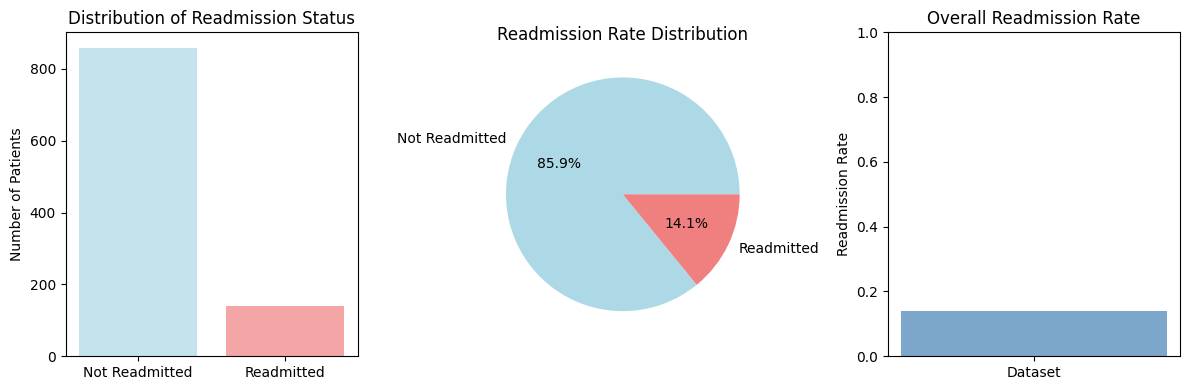

Readmission Statistics:
Not Readmitted: 859 patients (85.9%)
Readmitted: 141 patients (14.1%)


In [ ]:
# Analyze target variable
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
readmission_counts = df['readmitted'].value_counts()
plt.bar(['Not Readmitted', 'Readmitted'], readmission_counts.values,
        color=['lightblue', 'lightcoral'], alpha=0.7)
plt.title('Distribution of Readmission Status')
plt.ylabel('Number of Patients')

plt.subplot(1, 3, 2)
plt.pie(readmission_counts.values, labels=['Not Readmitted', 'Readmitted'],
        autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Readmission Rate Distribution')

plt.subplot(1, 3, 3)
readmission_rate = df['readmitted'].mean()
plt.bar(['Dataset'], [readmission_rate], color='steelblue', alpha=0.7)
plt.title('Overall Readmission Rate')
plt.ylabel('Readmission Rate')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"Readmission Statistics:")
print(f"Not Readmitted: {readmission_counts[0]} patients ({readmission_counts[0]/len(df)*100:.1f}%)")
print(f"Readmitted: {readmission_counts[1]} patients ({readmission_counts[1]/len(df)*100:.1f}%)")

# Key Clinical Indicators


# Key Clinical Indicators



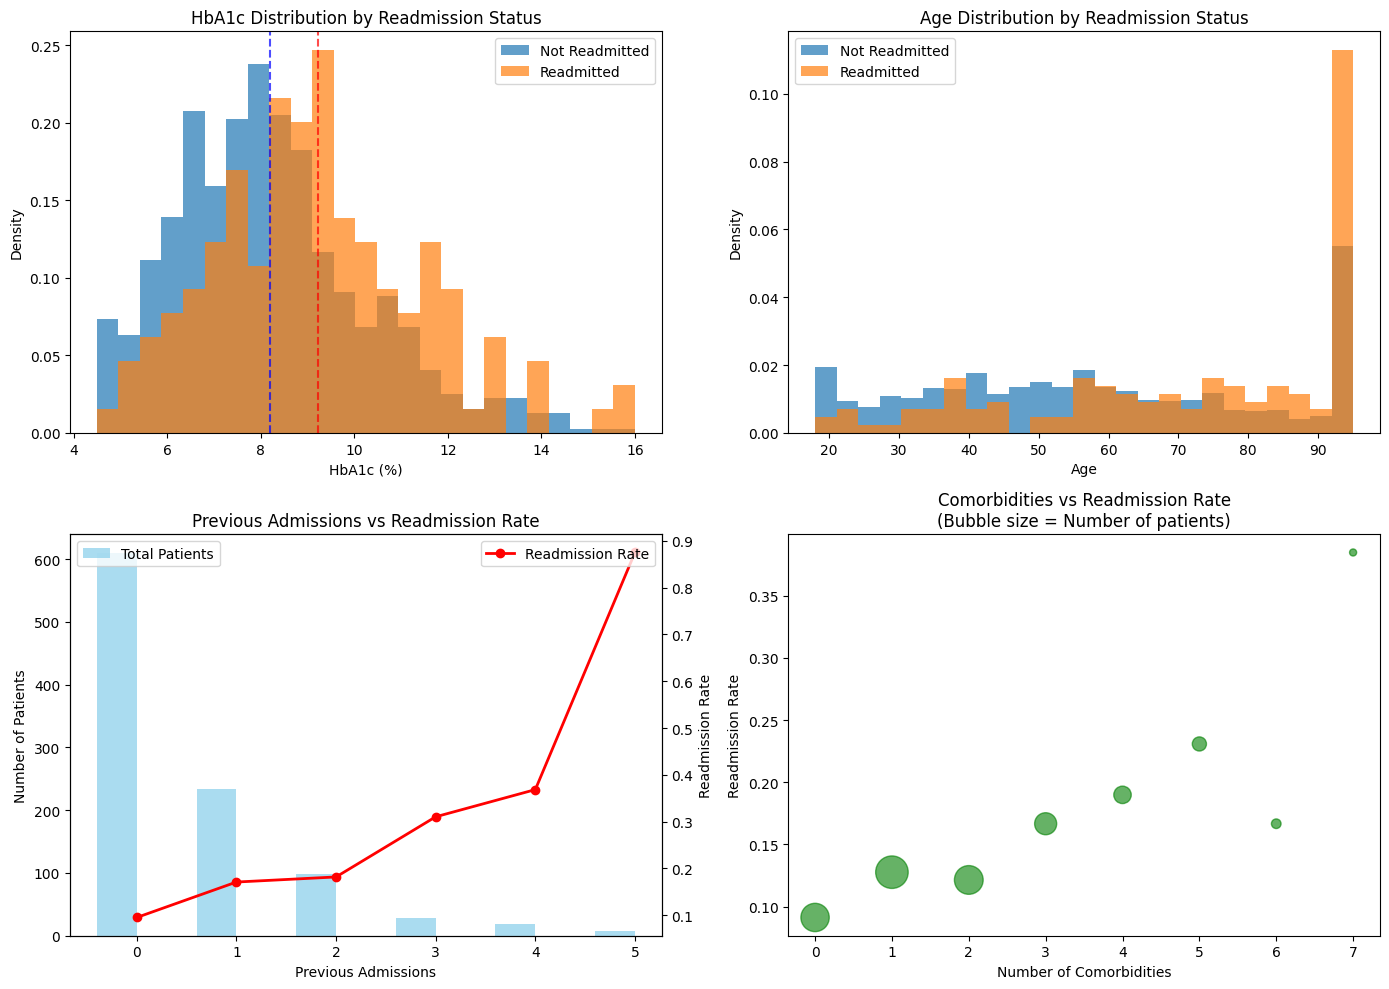

In [ ]:
# Analyze key clinical variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# HbA1c distribution by readmission status
not_readmitted = df[df['readmitted']==0]['hba1c'].dropna()
readmitted = df[df['readmitted']==1]['hba1c'].dropna()

axes[0,0].hist(not_readmitted, alpha=0.7, label='Not Readmitted', bins=25, density=True)
axes[0,0].hist(readmitted, alpha=0.7, label='Readmitted', bins=25, density=True)
axes[0,0].set_title('HbA1c Distribution by Readmission Status')
axes[0,0].set_xlabel('HbA1c (%)')
axes[0,0].set_ylabel('Density')
axes[0,0].legend()
axes[0,0].axvline(not_readmitted.mean(), color='blue', linestyle='--', alpha=0.7, label=f'Mean Not Readmitted: {not_readmitted.mean():.1f}')
axes[0,0].axvline(readmitted.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean Readmitted: {readmitted.mean():.1f}')

# Age distribution by readmission status
not_readmitted_age = df[df['readmitted']==0]['age']
readmitted_age = df[df['readmitted']==1]['age']

axes[0,1].hist(not_readmitted_age, alpha=0.7, label='Not Readmitted', bins=25, density=True)
axes[0,1].hist(readmitted_age, alpha=0.7, label='Readmitted', bins=25, density=True)
axes[0,1].set_title('Age Distribution by Readmission Status')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()

# Previous admissions analysis
prev_admit_analysis = df.groupby('previous_admissions')['readmitted'].agg(['count', 'mean']).reset_index()
prev_admit_analysis = prev_admit_analysis[prev_admit_analysis['count'] >= 5]  # Filter for statistical significance

axes[1,0].bar(prev_admit_analysis['previous_admissions'] - 0.2, prev_admit_analysis['count'],
              0.4, label='Total Patients', alpha=0.7, color='skyblue')
ax_twin = axes[1,0].twinx()
ax_twin.plot(prev_admit_analysis['previous_admissions'], prev_admit_analysis['mean'],
             'ro-', label='Readmission Rate', linewidth=2, markersize=6)
axes[1,0].set_xlabel('Previous Admissions')
axes[1,0].set_ylabel('Number of Patients')
ax_twin.set_ylabel('Readmission Rate')
axes[1,0].set_title('Previous Admissions vs Readmission Rate')
axes[1,0].legend(loc='upper left')
ax_twin.legend(loc='upper right')

# Comorbidities analysis
comorbidity_analysis = df.groupby('comorbidities')['readmitted'].agg(['count', 'mean']).reset_index()
comorbidity_analysis = comorbidity_analysis[comorbidity_analysis['count'] >= 10]

axes[1,1].scatter(comorbidity_analysis['comorbidities'], comorbidity_analysis['mean'],
                  s=comorbidity_analysis['count']*2, alpha=0.6, color='green')
axes[1,1].set_xlabel('Number of Comorbidities')
axes[1,1].set_ylabel('Readmission Rate')
axes[1,1].set_title('Comorbidities vs Readmission Rate\n(Bubble size = Number of patients)')

plt.tight_layout()
plt.show()

#Correlation Analysis


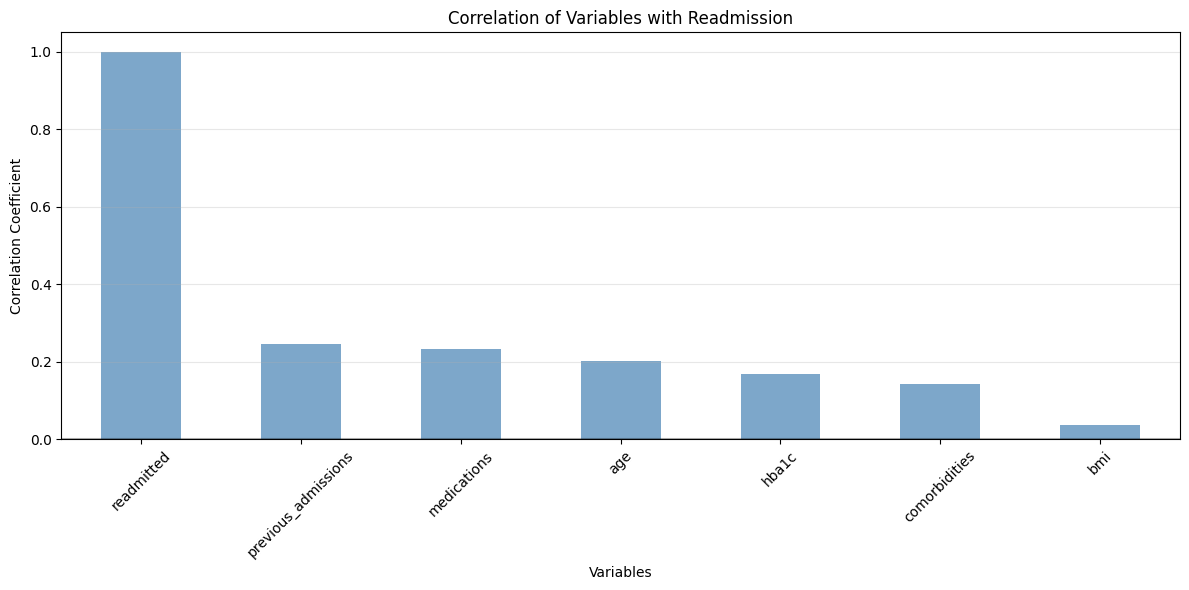

Correlation with Readmission:
readmitted             1.000
previous_admissions    0.245
medications            0.232
age                    0.201
hba1c                  0.167
comorbidities          0.141
bmi                    0.037
Name: readmitted, dtype: float64


In [ ]:
# Calculate correlation with readmission
numeric_cols = ['age', 'bmi', 'hba1c', 'comorbidities', 'medications',
                'previous_admissions', 'length_of_stay']

# Filter columns that exist in the dataset
existing_numeric_cols = [col for col in numeric_cols if col in df.columns]

correlations = df[existing_numeric_cols + ['readmitted']].corr()['readmitted'].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
correlations[:-1].plot(kind='bar', color='steelblue', alpha=0.7)
plt.title('Correlation of Variables with Readmission')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

print("Correlation with Readmission:")
print(correlations[:-1].round(3))

# Model Development
Feature Selection and Data Splitting

In [ ]:
# Select features for modeling (only those that exist in dataset)
all_feature_cols = ['age', 'gender', 'race', 'bmi', 'hba1c', 'diabetes_type',
                    'comorbidities', 'medications', 'previous_admissions',
                    'length_of_stay', 'admission_type', 'insurance',
                    'discharge_disposition', 'season']

# Filter to only existing columns
feature_cols = [col for col in all_feature_cols if col in df.columns]

X = df_encoded[feature_cols]
y = df_encoded['readmitted']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Selected features ({len(feature_cols)}): {feature_cols}")

Feature matrix shape: (1000, 14)
Target vector shape: (1000,)
Selected features (14): ['age', 'gender', 'race', 'bmi', 'hba1c', 'diabetes_type', 'comorbidities', 'medications', 'previous_admissions', 'length_of_stay', 'admission_type', 'insurance', 'discharge_disposition', 'season']


# Split data into training and testing sets


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} patients")
print(f"Testing set size: {X_test.shape[0]} patients")
print(f"Training set readmission rate: {y_train.mean():.1%}")
print(f"Testing set readmission rate: {y_test.mean():.1%}")

Training set size: 800 patients
Testing set size: 200 patients
Training set readmission rate: 14.1%
Testing set readmission rate: 14.0%


#Feature Scaling


In [ ]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")
print(f"Training features mean: {X_train_scaled.mean():.3f}")
print(f"Training features std: {X_train_scaled.std():.3f}")

Feature scaling completed
Training features mean: -0.000
Training features std: 1.000


#Model Training


In [ ]:
# Train logistic regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

print("Logistic regression model trained successfully")
print(f"Model convergence: {logistic_model.n_iter_} iterations")

Logistic regression model trained successfully
Model convergence: [9] iterations


#Model Evaluation
Predictions and Basic Metrics


In [ ]:
# Make predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Get prediction probabilities
y_train_prob = logistic_model.predict_proba(X_train_scaled)[:, 1]
y_test_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calculate basic accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Testing Accuracy: {test_accuracy:.3f}")
print(f"Overfitting Check: {abs(train_accuracy - test_accuracy):.3f}")

Training Accuracy: 0.876
Testing Accuracy: 0.880
Overfitting Check: 0.004


#Detailed Performance Metrics


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate performance metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

print("Model Performance Metrics:")
print("-" * 40)
print(f"Accuracy:    {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f} (Recall)")
print(f"Specificity: {specificity:.3f}")
print(f"Precision:   {precision:.3f}")
print(f"F1-Score:    {f1_score:.3f}")

Model Performance Metrics:
----------------------------------------
Accuracy:    0.880
Sensitivity: 0.250 (Recall)
Specificity: 0.983
Precision:   0.700
F1-Score:    0.368


#Confusion Matrix Visualization


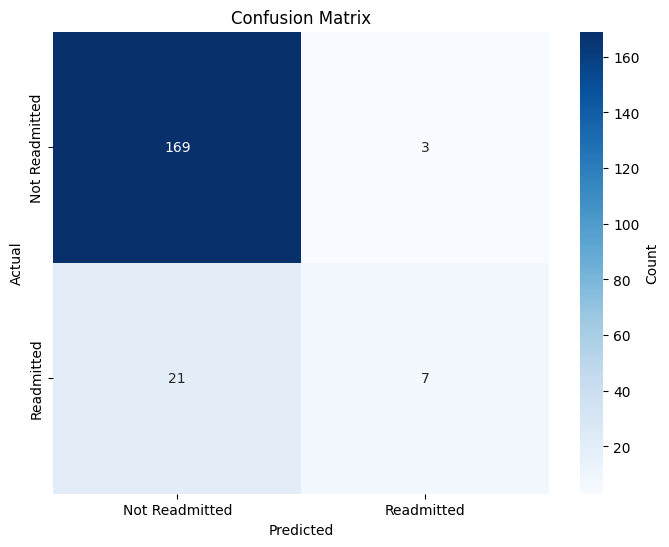


Confusion Matrix Interpretation:
True Negatives (TN): 169 - Correctly predicted no readmission
False Positives (FP): 3 - Incorrectly predicted readmission
False Negatives (FN): 21 - Missed readmissions
True Positives (TP): 7 - Correctly predicted readmission


In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print confusion matrix interpretation
print("\nConfusion Matrix Interpretation:")
print(f"True Negatives (TN): {tn} - Correctly predicted no readmission")
print(f"False Positives (FP): {fp} - Incorrectly predicted readmission")
print(f"False Negatives (FN): {fn} - Missed readmissions")
print(f"True Positives (TP): {tp} - Correctly predicted readmission")

#ROC Curve Analysis


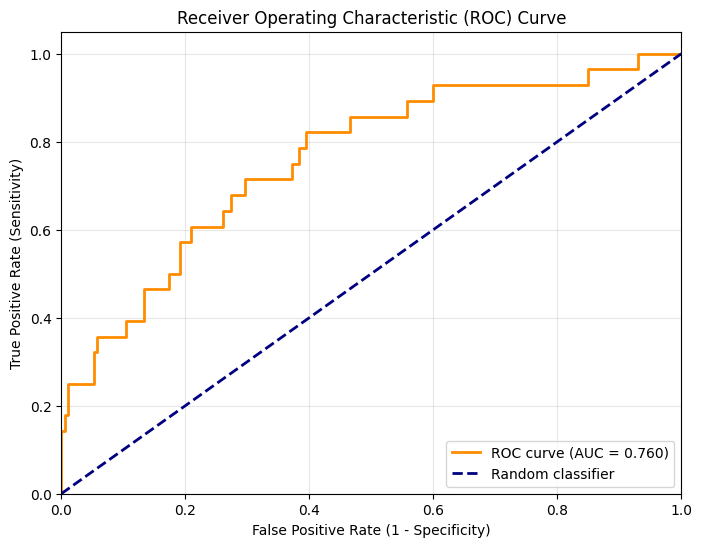

Area Under the Curve (AUC): 0.760
AUC Interpretation:
- 0.5: Random prediction
- 0.7-0.8: Acceptable performance
- 0.8-0.9: Excellent performance
- 0.9-1.0: Outstanding performance


In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
auc_score = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Area Under the Curve (AUC): {auc_score:.3f}")
print("AUC Interpretation:")
print("- 0.5: Random prediction")
print("- 0.7-0.8: Acceptable performance")
print("- 0.8-0.9: Excellent performance")
print("- 0.9-1.0: Outstanding performance")

#Feature Importance Analysis


Top 10 Most Important Features:
                  feature  coefficient  abs_coefficient
0                     age     0.638388         0.638388
8     previous_admissions     0.610533         0.610533
4                   hba1c     0.558535         0.558535
6           comorbidities     0.372685         0.372685
1                  gender     0.319675         0.319675
9          length_of_stay    -0.309284         0.309284
7             medications     0.233485         0.233485
2                    race    -0.134731         0.134731
12  discharge_disposition    -0.121155         0.121155
3                     bmi     0.120616         0.120616


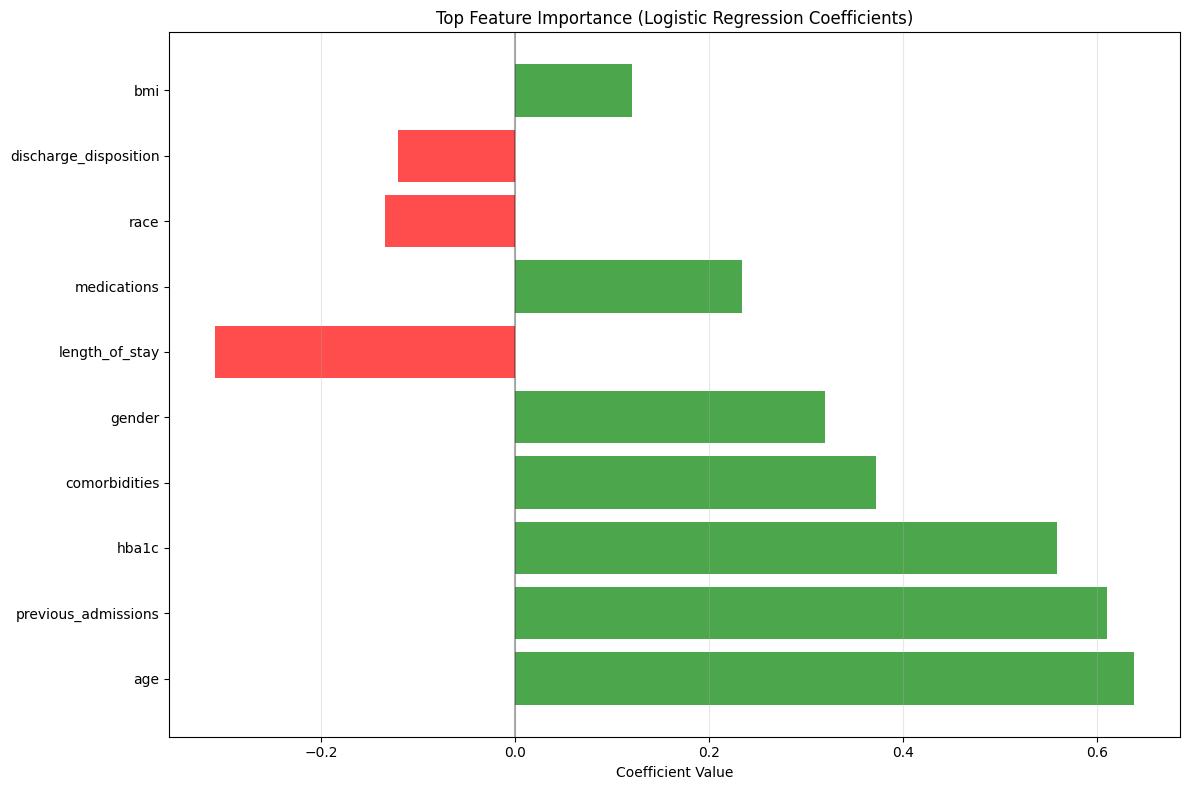

In [ ]:
# Get feature importance (coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': logistic_model.coef_[0],
    'abs_coefficient': np.abs(logistic_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(min(10, len(feature_importance)))
colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top Feature Importance (Logistic Regression Coefficients)')
plt.grid(axis='x', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# Model Interpretation


In [ ]:
# Interpret model coefficients
print("Model Interpretation:")
print("-" * 50)

for idx, row in feature_importance.head(5).iterrows():
    feature = row['feature']
    coef = row['coefficient']

    if coef > 0:
        direction = "increases"
        impact = "higher"
    else:
        direction = "decreases"
        impact = "lower"

    print(f"• {feature}: {direction} readmission probability")
    print(f"  Coefficient: {coef:.3f} ({impact} values = {direction.replace('s', '')}d risk)")
    print()

Model Interpretation:
--------------------------------------------------
• age: increases readmission probability
  Coefficient: 0.638 (higher values = increaed risk)

• previous_admissions: increases readmission probability
  Coefficient: 0.611 (higher values = increaed risk)

• hba1c: increases readmission probability
  Coefficient: 0.559 (higher values = increaed risk)

• comorbidities: increases readmission probability
  Coefficient: 0.373 (higher values = increaed risk)

• gender: increases readmission probability
  Coefficient: 0.320 (higher values = increaed risk)



# Risk Score Analysis

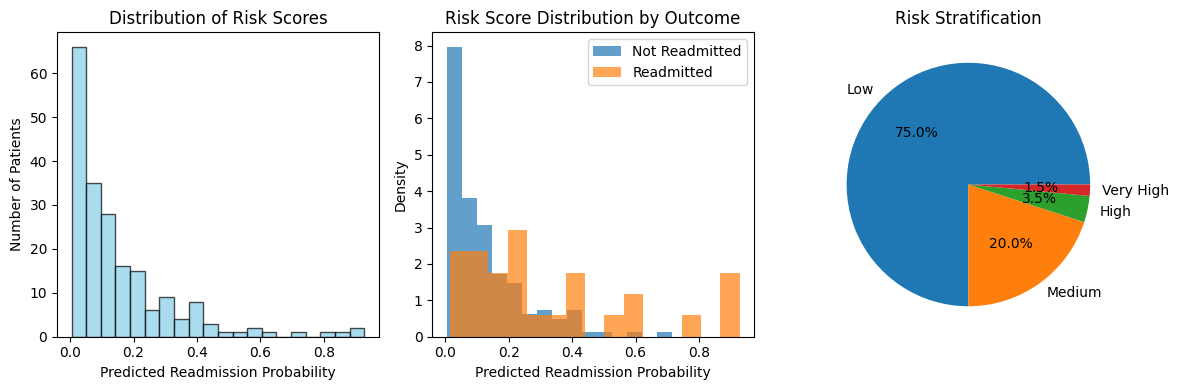

In [ ]:
# Create risk score distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(y_test_prob, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Risk Scores')
plt.xlabel('Predicted Readmission Probability')
plt.ylabel('Number of Patients')

plt.subplot(1, 3, 2)
plt.hist(y_test_prob[y_test == 0], bins=15, alpha=0.7, label='Not Readmitted', density=True)
plt.hist(y_test_prob[y_test == 1], bins=15, alpha=0.7, label='Readmitted', density=True)
plt.title('Risk Score Distribution by Outcome')
plt.xlabel('Predicted Readmission Probability')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 3, 3)
# Risk stratification
risk_thresholds = [0.2, 0.5, 0.8]
risk_labels = ['Low', 'Medium', 'High', 'Very High']
risk_categories = pd.cut(y_test_prob, bins=[0] + risk_thresholds + [1], labels=risk_labels)
risk_counts = risk_categories.value_counts()
plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%')
plt.title('Risk Stratification')

plt.tight_layout()
plt.show()

#Results Summary


In [ ]:
# Create results summary
results_summary = {
    'Model': 'Logistic Regression',
    'Dataset Size': len(df),
    'Training Size': len(X_train),
    'Testing Size': len(X_test),
    'Features Used': len(feature_cols),
    'Accuracy': f"{accuracy:.3f}",
    'Sensitivity': f"{sensitivity:.3f}",
    'Specificity': f"{specificity:.3f}",
    'Precision': f"{precision:.3f}",
    'F1-Score': f"{f1_score:.3f}",
    'AUC': f"{auc_score:.3f}",
    'Baseline Readmission Rate': f"{y.mean():.1%}"
}

print("FINAL RESULTS SUMMARY")
print("=" * 50)
for key, value in results_summary.items():
    print(f"{key:<25}: {value}")

FINAL RESULTS SUMMARY
Model                    : Logistic Regression
Dataset Size             : 1000
Training Size            : 800
Testing Size             : 200
Features Used            : 14
Accuracy                 : 0.880
Sensitivity              : 0.250
Specificity              : 0.983
Precision                : 0.700
F1-Score                 : 0.368
AUC                      : 0.760
Baseline Readmission Rate: 14.1%


#Clinical Relevance and Recommendations


In [ ]:
# Risk stratification
risk_scores = y_test_prob
low_risk = np.sum(risk_scores < 0.3)
medium_risk = np.sum((risk_scores >= 0.3) & (risk_scores < 0.7))
high_risk = np.sum(risk_scores >= 0.7)

print("Risk Stratification of Test Patients:")
print(f"Low Risk (< 30%):     {low_risk} patients ({low_risk/len(y_test)*100:.1f}%)")
print(f"Medium Risk (30-70%): {medium_risk} patients ({medium_risk/len(y_test)*100:.1f}%)")
print(f"High Risk (> 70%):    {high_risk} patients ({high_risk/len(y_test)*100:.1f}%)")

# Calculate actual readmission rates by risk category
low_risk_actual = y_test[risk_scores < 0.3].mean() if low_risk > 0 else 0
medium_risk_actual = y_test[(risk_scores >= 0.3) & (risk_scores < 0.7)].mean() if medium_risk > 0 else 0
high_risk_actual = y_test[risk_scores >= 0.7].mean() if high_risk > 0 else 0

print(f"\nActual Readmission Rates by Risk Category:")
print(f"Low Risk:    {low_risk_actual:.1%}")
print(f"Medium Risk: {medium_risk_actual:.1%}")
print(f"High Risk:   {high_risk_actual:.1%}")

Risk Stratification of Test Patients:
Low Risk (< 30%):     169 patients (84.5%)
Medium Risk (30-70%): 26 patients (13.0%)
High Risk (> 70%):    5 patients (2.5%)

Actual Readmission Rates by Risk Category:
Low Risk:    10.1%
Medium Risk: 26.9%
High Risk:   80.0%


# Recommendations


In [ ]:
print("\nClinical Recommendations:")
print("1. Focus discharge planning on high-risk patients (> 70% probability)")
print("2. Consider additional follow-up for medium-risk patients")
print("3. Key risk factors to monitor based on model:")

# Show top 3 risk factors
top_risk_factors = feature_importance.head(3)
for idx, row in top_risk_factors.iterrows():
    print(f"   - {row['feature']}: {'Increases' if row['coefficient'] > 0 else 'Decreases'} risk")

print("4. Model can help prioritize limited healthcare resources")
print("5. Regular model retraining recommended as new data becomes available")


Clinical Recommendations:
1. Focus discharge planning on high-risk patients (> 70% probability)
2. Consider additional follow-up for medium-risk patients
3. Key risk factors to monitor based on model:
   - age: Increases risk
   - previous_admissions: Increases risk
   - hba1c: Increases risk
4. Model can help prioritize limited healthcare resources
5. Regular model retraining recommended as new data becomes available
